In [1]:
import aux_tools
import os
%matplotlib inline

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(os.getcwd(), fig_id + "." + fig_extension)
    print(f"Saving figure {fig_id} to {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

In [14]:
# Pipeline

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #('imputer', Imputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('selector', aux_tools.DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    #('robust_scaler', RobustScaler()),
])

sliding_window_pipeline = Pipeline([
    ('selector', aux_tools.DataFrameSelector('relative_day_position')),
    ('revel', aux_tools.DataFrameRevel()),
    ('cat_encoder', aux_tools.CategoricalEncoder(encoding="onehot-dense")),
])


In [16]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("sliding_window_pipeline", sliding_window_pipeline),
])

In [17]:
from sklearn.utils import shuffle

df = shuffle(df)

fulldata = full_pipeline.fit_transform(df)
cat_encoder = aux_tools.CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [7]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

ada_class = AdaBoostClassifier(random_state=42,
                               base_estimator=svm.LinearSVC(),
                               algorithm='SAMME')


scores = cross_val_score(ada_class,
                         fulldata,
                         fulldata_labels_ordinal.ravel()
                         #scoring='accuracy'
                        )

print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.0074)


In [8]:
[aux_tools.labnames[x] for x in list(cat_encoder.categories_[0])]

['Lab-D', 'Lab-A', 'Lab-C', 'Lab-1', 'Lab-2', 'Lab-B']

Automatically created module for IPython interactive environment
Normalized confusion matrix
[[1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.12e-04]
 [0.00e+00 9.95e-01 3.29e-03 9.41e-04 1.18e-04 7.06e-04]
 [1.90e-02 1.87e-02 9.45e-01 1.05e-02 4.75e-03 1.58e-03]
 [0.00e+00 0.00e+00 0.00e+00 9.68e-01 3.24e-02 0.00e+00]
 [1.57e-04 0.00e+00 1.57e-04 4.01e-02 9.60e-01 0.00e+00]
 [6.70e-04 1.00e-03 6.70e-04 1.00e-03 3.35e-04 9.96e-01]]
Saving figure conf_mat_ada to /home/luminoso/thesis/gjc-ml-2018abr_final/conf_mat_ada.pdf


TypeError: plot_confusion_matrix() got an unexpected keyword argument 'hide_zeros'

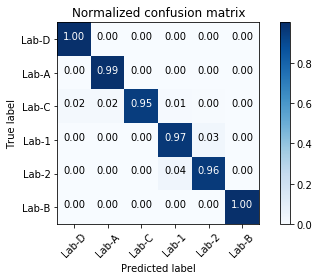

In [9]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

X = fulldata
y = fulldata_labels_ordinal.ravel()

class_names = [aux_tools.labnames[x] for x in list(cat_encoder.categories_[0])]


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = AdaBoostClassifier(random_state=42,
                               base_estimator=svm.LinearSVC(),
                               algorithm='SAMME',
                               n_estimators=5)

classifier.fit(X, y)

y_pred = cross_val_predict(classifier, X, y, cv=3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

save_fig('conf_mat_ada')


plt.figure()

row_sums = cnf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = cnf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion errors', hide_zeros=True)

save_fig('conf_mat_errors_ada')

plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier



In [ ]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

X = fulldata
y = fulldata_labels_ordinal.ravel()

class_names = [aux_tools.labnames[x] for x in list(cat_encoder.categories_[0])]


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

classifier.fit(X, y)

y_pred = cross_val_predict(classifier, X, y, cv=3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

save_fig('conf_mat_adaGD')


plt.figure()

row_sums = cnf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = cnf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion errors')

save_fig('conf_mat_errors_adaGD')

plt.show()

In [ ]:
save_fig('conf_mat_adaGD')


In [ ]:
ada_class = GradientBoostingClassifier(random_state=42)


scores = cross_val_score(ada_class,
                         fulldata,
                         fulldata_labels_ordinal.ravel()
                         #scoring='accuracy'
                        )

print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [26]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(fulldata)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Saving figure pca_variance_095 to /home/luminoso/thesis/gjc-ml-2018abr_final/pca_variance_095.pdf


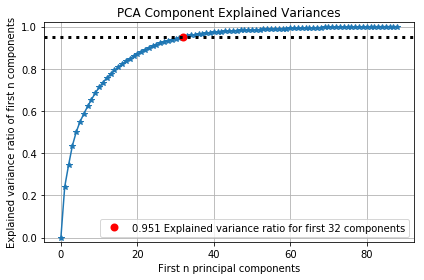

In [27]:
import scikitplot as skplt

skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.95)
save_fig('pca_variance_095')
plt.show()


In [ ]:
# confusion matrix

In [ ]:
# remove everything except the worse case

In [38]:
df_worsecase = df[df.entity != 'np_x58pc.raw']
df_worsecase = df_worsecase[df_worsecase.entity != 'np_tohiba.raw']
df_worsecase = df_worsecase[df_worsecase.entity != 'np_freebsd.raw'] 
df_worsecase = df_worsecase[df_worsecase.entity != 'np_nuc.raw'] 

In [39]:
fulldata_worsecase = full_pipeline.fit_transform(df_worsecase)
cat_encoder = aux_tools.CategoricalEncoder(encoding="ordinal")
fulldata_labels = df_worsecase['entity'].values.reshape(-1, 1)
fulldata_worsecase_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [40]:
ada_class = AdaBoostClassifier(random_state=42,
                               base_estimator=svm.LinearSVC(),
                               algorithm='SAMME')


scores = cross_val_score(ada_class,
                         fulldata_worsecase,
                         fulldata_worsecase_labels_ordinal.ravel()
                         #scoring='accuracy'
                        )

print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.0011)


In [100]:
AdaBoostClassifier(random_state=42,
                               base_estimator=svm.LinearSVC(),
                               algorithm='SAMME')

['Lab-C', 'Lab-1']

Automatically created module for IPython interactive environment
Saving figure adaerrors to /home/luminoso/thesis/gjc-ml-2018abr_final/adaerrors.pdf


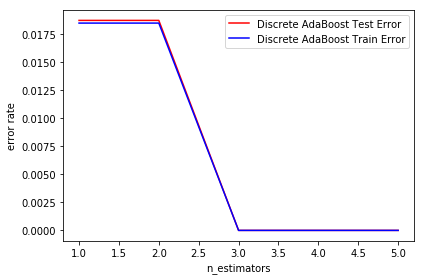

In [26]:
print(__doc__)

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>,
#         Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 5
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X = fulldata
y = fulldata_labels_ordinal.ravel()       


X_train, X_test, y_train, y_test = train_test_split(X, y, #random_state=42,
                                                    test_size=0.60)

dt_stump = svm.LinearSVC()
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)


ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")

ada_discrete.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

#ax.plot([1, n_estimators], [dt_err] * 2, 'k--', label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))

for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)


ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')

#ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
#leg.get_frame().set_alpha(0.7)

save_fig('adaerrors')

plt.show()

Automatically created module for IPython interactive environment
Saving figure adaerrors to /home/luminoso/thesis/gjc-ml-2018abr_final/adaerrors.pdf


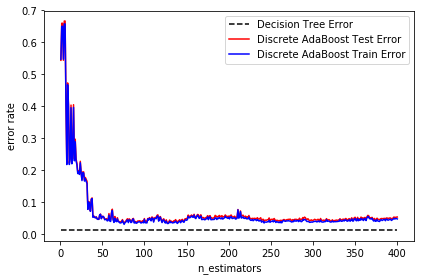

In [24]:
print(__doc__)

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>,
#         Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 400
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X = fulldata
y = fulldata_labels_ordinal.ravel()       


X_train, X_test, y_train, y_test = train_test_split(X, y, #random_state=42,
                                                    test_size=0.60)

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))

for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)


ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')

#ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
#leg.get_frame().set_alpha(0.7)

save_fig('adaerrors')

plt.show()

Automatically created module for IPython interactive environment
Saving figure adaerrors to /home/luminoso/thesis/gjc-ml-2018abr_final/adaerrors.pdf


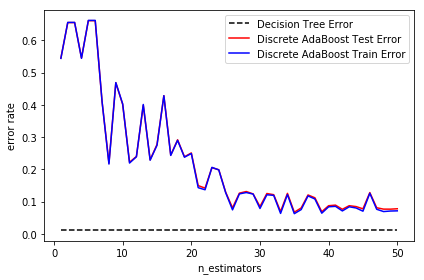

In [25]:
print(__doc__)

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>,
#         Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 50
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X = fulldata
y = fulldata_labels_ordinal.ravel()       


X_train, X_test, y_train, y_test = train_test_split(X, y, #random_state=42,
                                                    test_size=0.60)

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))

for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)


ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')

#ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
#leg.get_frame().set_alpha(0.7)

save_fig('adaerrors')

plt.show()